In [1]:
!pip install finance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
📥 Baixando dados da B3...


C:\Users\igorc\AppData\Local\Temp\ipykernel_5608\3578925560.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data.rename(columns=names_map, inplace=True)


✅ Dados baixados e processados com sucesso.

--- 📊 TABELA DE RISCO QUANTITATIVO ---
 Retorno Anual Volatilidade Sharpe Ratio Max Drawdown Skewness Kurtosis É Normal?
Ticker       
Petrobras 24.13% 41.63% 0.29 -63.36% -1.32 21.65 False
IBOVESPA 5.67% 24.28% -0.19 -46.82% -1.04 20.79 False
BTG Pactual 22.29% 45.41% 0.23 -68.01% 0.39 16.41 False
Vale 17.49% 35.39% 0.17 -41.34% 0.82 11.86 False
Weg 20.05% 36.80% 0.23 -49.51% -0.25 9.21 False
Itau 9.20% 30.35% -0.05 -43.75% -0.40 8.33 False
Renner -16.41% 46.92% -0.52 -76.38% -0.11 4.11 False
Taesa 15.30% 18.79% 0.22 -23.69% 0.05 3.79 False
Magalu -34.57% 69.18% -0.59 -97.73% 0.33 3.71 False


--- 🎨 Gerando Dashboard Executivo (Risco Quant)... ---


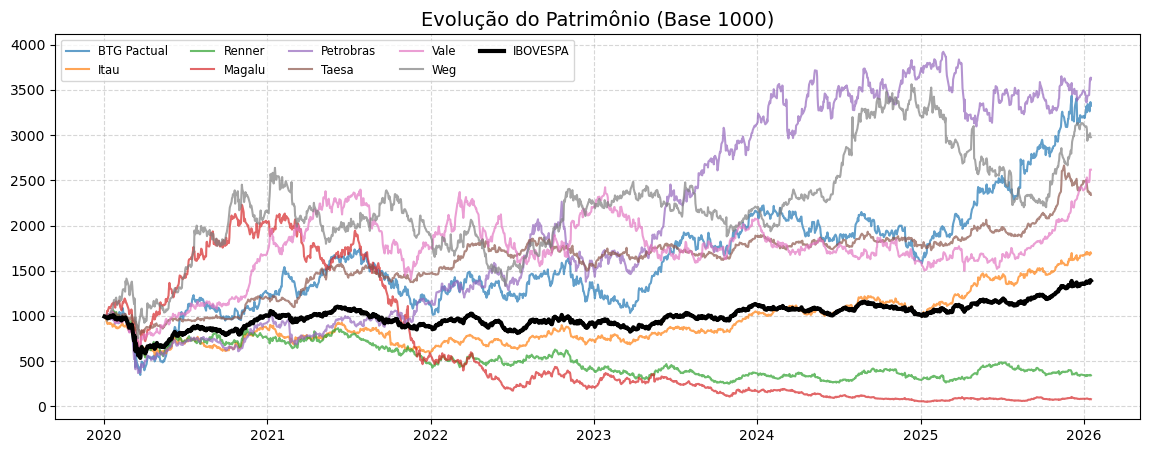


--- 🎨 Gerando Dashboard Executivo (Layout Expandido)... ---


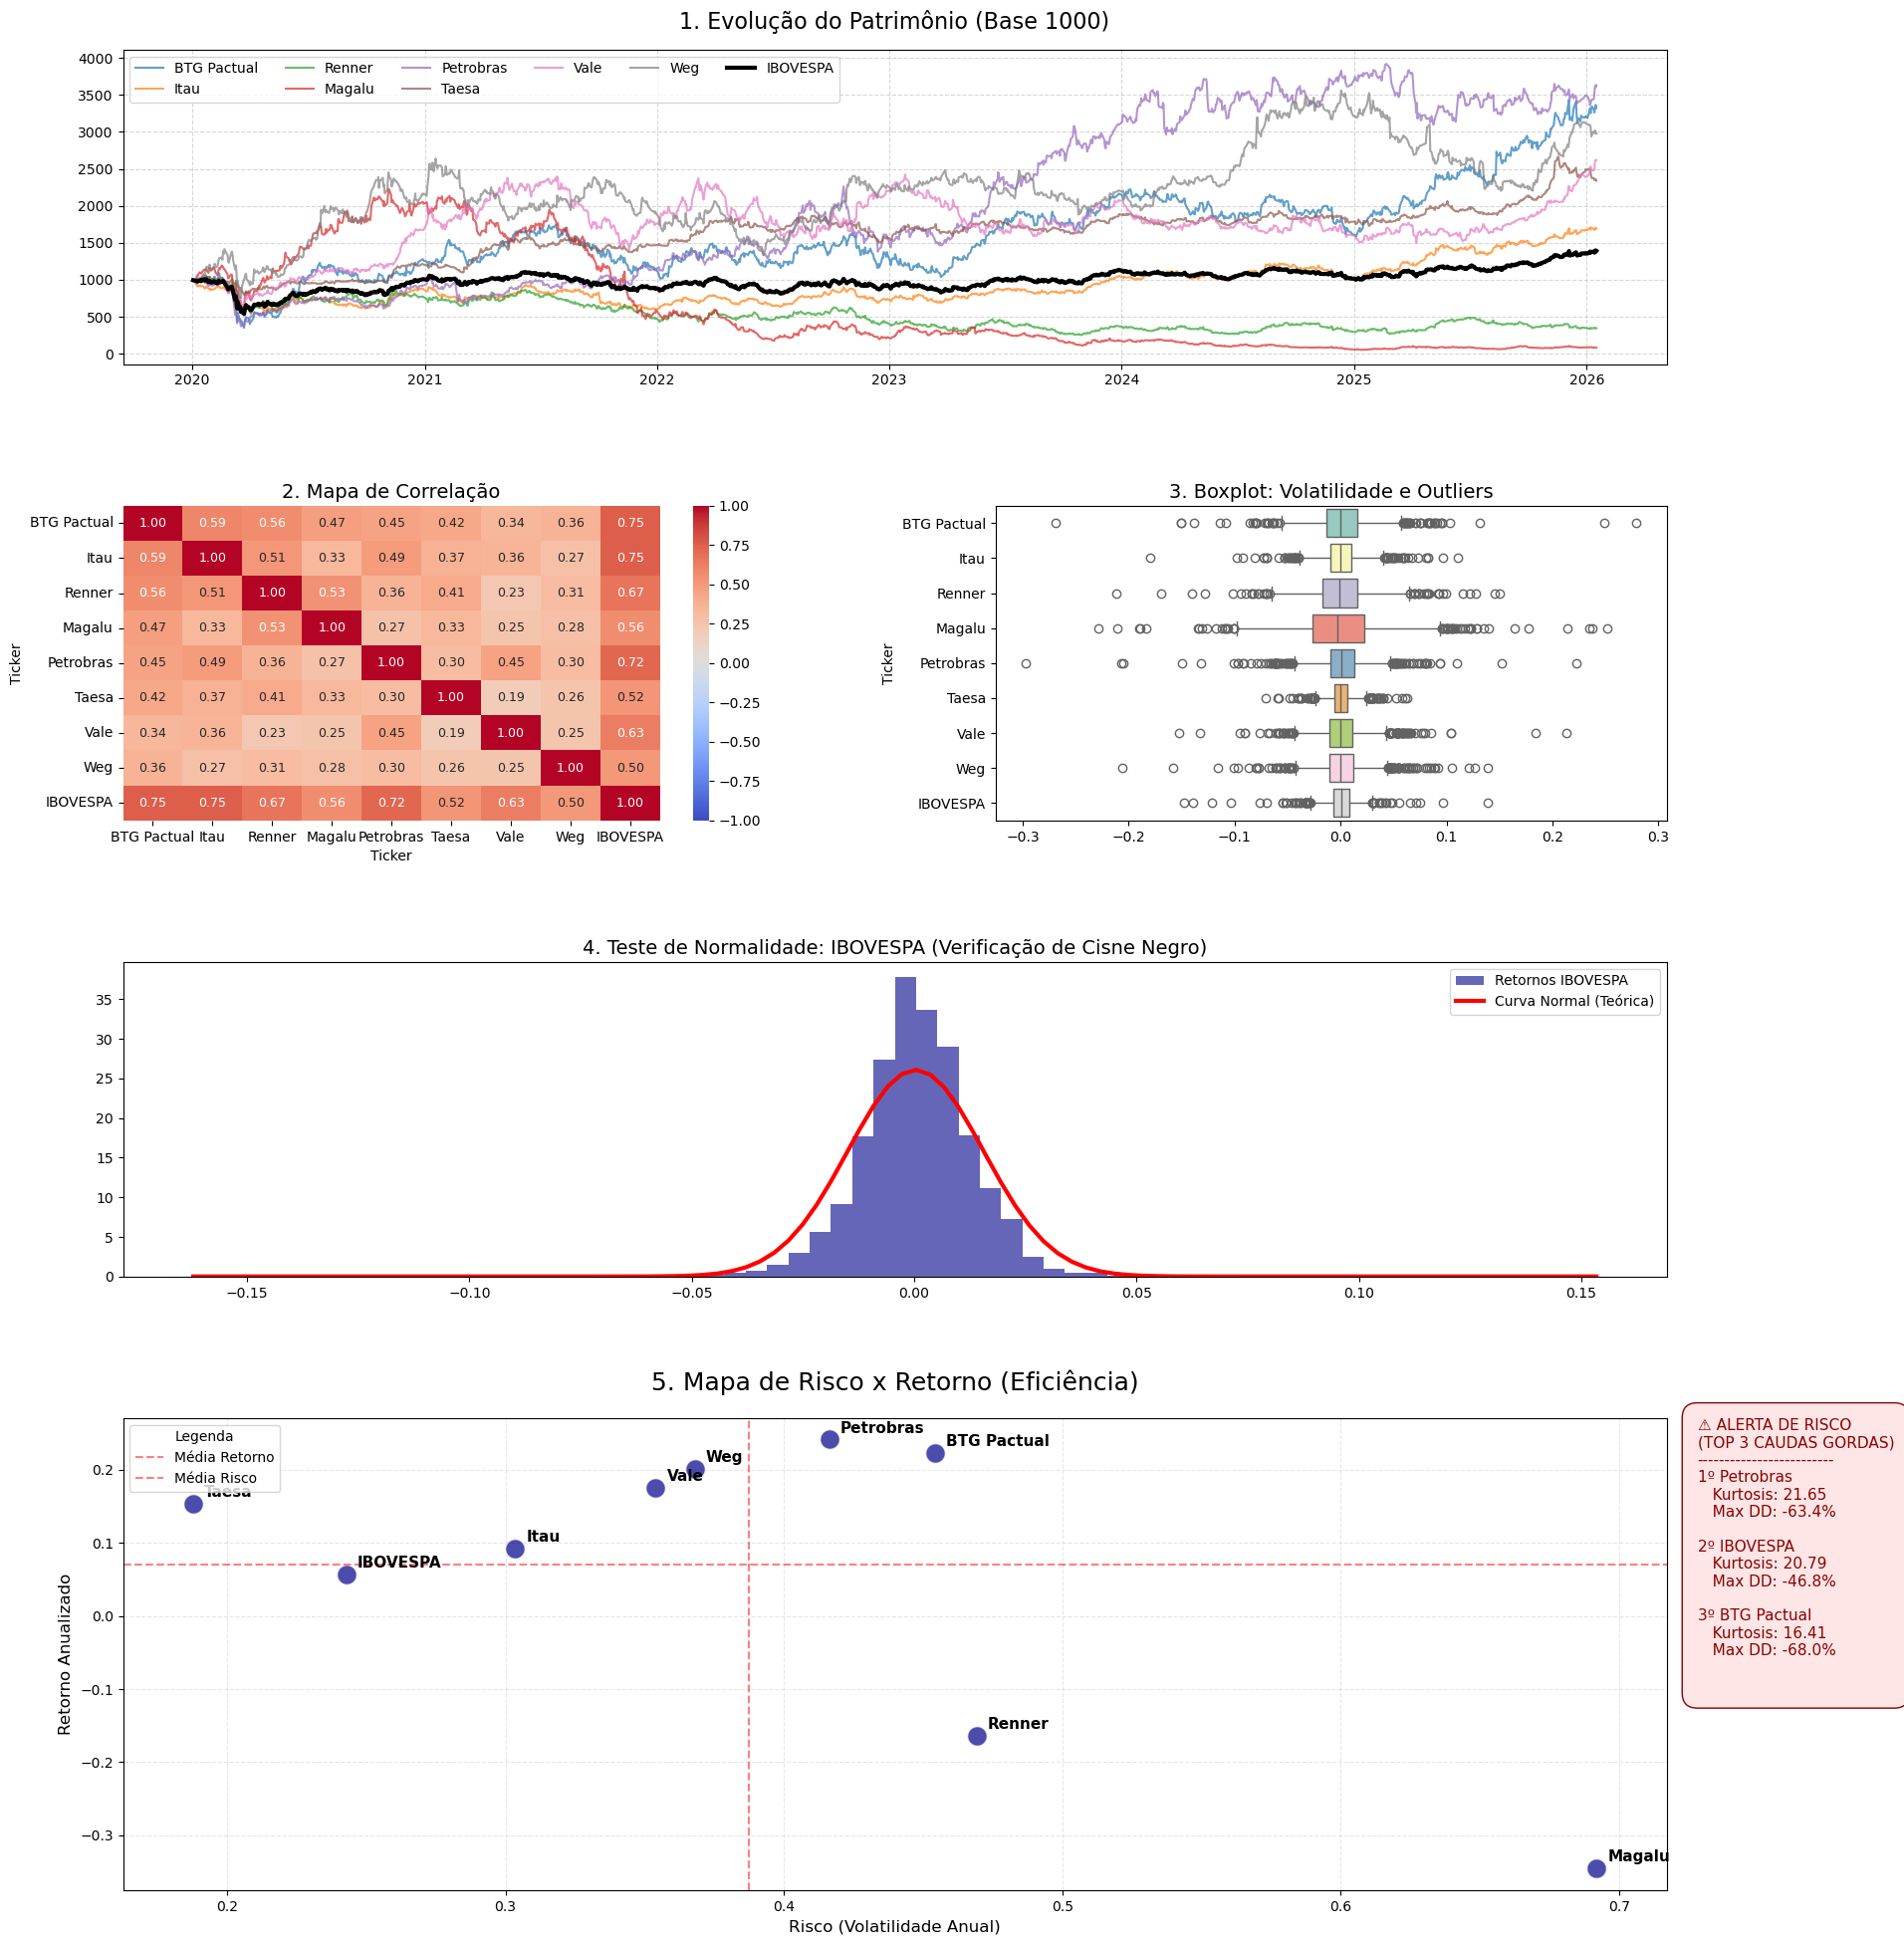

In [13]:
# CONFIGURAÇÃO DO AMBIENTE
%load_ext autoreload
%autoreload 2
    
'''
Com este comando, caso alteradoo o arquivo dados_mercado.py,
o Jupyter recarregue as mudanças automaticamente sem precisar reiniciar o kernel.
'''


# CONFIGURAÇÃO DO AMBIENTE
%load_ext autoreload
%autoreload 2

# ==============================================================================
# 1. CONFIGURAÇÃO E BIBLIOTECAS
# ==============================================================================
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import warnings

# --- CORREÇÃO DEFINITIVA DE IMPORTAÇÃO ---
# Importamos as funções direto. Assim não tem erro de nome.
from scipy.stats import skew, kurtosis, norm 

# Ignorar avisos
warnings.simplefilter(action='ignore', category=FutureWarning)

# ==============================================================================
# 2. MOTOR MATEMÁTICO (CLASSE DM CORRIGIDA)
# ==============================================================================
class dm:
    """
    Classe auxiliar que simula o módulo 'dados_mercado'.
    """
    @staticmethod
    def annualize_rets(r, periods_per_year=252):
        compounded_growth = (1 + r).prod()
        n_periods = r.shape[0]
        return compounded_growth**(periods_per_year/n_periods) - 1

    @staticmethod
    def annualize_vol(r, periods_per_year=252):
        return r.std() * (periods_per_year**0.5)

    @staticmethod
    def sharpe_ratio(r, riskfree_rate, periods_per_year=252):
        rf_per_period = (1 + riskfree_rate)**(1/periods_per_year) - 1
        excess_ret = r - rf_per_period
        ann_ex_ret = dm.annualize_rets(excess_ret, periods_per_year)
        ann_vol = dm.annualize_vol(r, periods_per_year)
        return ann_ex_ret / ann_vol

    @staticmethod
    def drawdown(return_series: pd.Series):
        wealth_index = 1000 * (1 + return_series).cumprod()
        previous_peaks = wealth_index.cummax()
        drawdowns = (wealth_index - previous_peaks) / previous_peaks
        return pd.DataFrame({"Wealth": wealth_index, "Previous Peak": previous_peaks, "Drawdown": drawdowns})

    @staticmethod
    def skewness(r):
        # USA DIRETO A FUNÇÃO IMPORTADA (SEM PREFIXO)
        return skew(r)

    @staticmethod
    def kurtosis(r):
        # USA DIRETO A FUNÇÃO IMPORTADA (SEM PREFIXO)
        return kurtosis(r)

# ==============================================================================
# 3. EXTRAÇÃO E TRATAMENTO DE DADOS (ETL)
# ==============================================================================

analyzed_groups = {
    'Benchmark': ['^BVSP'],
    'Commodity': ['VALE3.SA', 'PETR4.SA'],
    'Sistema financeiro': ['ITUB4.SA', 'BPAC11.SA'],
    'Varejo': ['MGLU3.SA', 'LREN3.SA'],
    'DEFENSIVA': ['WEGE3.SA', 'TAEE11.SA'],
}

names_map = {
    '^BVSP': 'IBOVESPA',
    'VALE3.SA': 'Vale', 'PETR4.SA': 'Petrobras',
    'ITUB4.SA': 'Itau', 'BPAC11.SA': 'BTG Pactual',
    'MGLU3.SA': 'Magalu', 'LREN3.SA': 'Renner',
    'WEGE3.SA': 'Weg', 'TAEE11.SA': 'Taesa'
}

print("📥 Baixando dados da B3...")
acoes = [item for sublist in analyzed_groups.values() for item in sublist]

# Download via YFinance
raw_data = yf.download(acoes, start='2020-01-01', auto_adjust=True, progress=False)

try:
    close_data = raw_data['Close']
except KeyError:
    close_data = raw_data

close_data.rename(columns=names_map, inplace=True)

# Persistência (Salvar ZIP)
data_folder = 'dados'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

csv_path = os.path.join(data_folder, 'cotacoes.csv')
close_data.to_csv(csv_path)

print("✅ Dados baixados e processados com sucesso.")

# ==============================================================================
# 4. CÁLCULO DE RISCO
# ==============================================================================

retornos = close_data.pct_change().dropna()
dias_ano = 252
taxa_livre_risco = 0.1075 

# Cálculos
ret_anual = dm.annualize_rets(retornos, dias_ano)
vol_anual = dm.annualize_vol(retornos, dias_ano)
sharpe = dm.sharpe_ratio(retornos, taxa_livre_risco, dias_ano)
skew_series = retornos.apply(dm.skewness)
kurt_series = retornos.apply(dm.kurtosis)
max_dd = retornos.apply(lambda x: dm.drawdown(x)['Drawdown'].min())
is_normal = kurt_series.apply(lambda x: x < 3.5 and x > 2.5)

# Tabela Final
tabela = pd.DataFrame({
    "Retorno Anual": ret_anual,
    "Volatilidade": vol_anual,
    "Sharpe Ratio": sharpe,
    "Max Drawdown": max_dd,
    "Skewness": skew_series,
    "Kurtosis": kurt_series,
    "É Normal?": is_normal
})

print("\n--- 📊 TABELA DE RISCO QUANTITATIVO ---")
print(tabela.sort_values(by="Kurtosis", ascending=False).style.format({
    "Retorno Anual": "{:.2%}", "Volatilidade": "{:.2%}", "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}", "Skewness": "{:.2f}", "Kurtosis": "{:.2f}"
}).to_string())

# ==============================================================================
# 5. DASHBOARD VISUAL COMPLETO (4 EM 1)
# ==============================================================================

print("\n--- 🎨 Gerando Dashboard Executivo (Risco Quant)... ---")

# --- GRÁFICO 1: EVOLUÇÃO DO PATRIMÔNIO (Separado para dar destaque) ---
fig0, ax0 = plt.subplots(figsize=(14, 5))
wealth_index = 1000 * (1 + retornos).cumprod()
colors = sns.color_palette("tab10", len(retornos.columns))

for i, col in enumerate(wealth_index.columns):
    lw = 3 if col == 'IBOVESPA' else 1.5
    alpha = 1.0 if col == 'IBOVESPA' else 0.7
    color = 'black' if col == 'IBOVESPA' else colors[i]
    ax0.plot(wealth_index.index, wealth_index[col], label=col, linewidth=lw, alpha=alpha, color=color)

ax0.set_title('Evolução do Patrimônio (Base 1000)', fontsize=14)
ax0.legend(loc='upper left', ncol=5, fontsize='small')
ax0.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ==============================================================================
# 5. DASHBOARD VISUAL "PREMIUM" (LAYOUT VERTICAL)
# ==============================================================================

print("\n--- 🎨 Gerando Dashboard Executivo (Layout Expandido)... ---")

# Aumentamos a altura para (20, 24) para dar "respiro" entre os gráficos
fig = plt.figure(figsize=(20, 24)) 

# Criamos um Grid de 4 linhas e 2 colunas
# height_ratios define que o Scatter (linha 3) será maior que os outros
gs = fig.add_gridspec(4, 2, height_ratios=[1, 1, 1, 1.5], hspace=0.4, wspace=0.3)

# ----------------------------------------------------------------------
# LINHA 1: EVOLUÇÃO DO PATRIMÔNIO (Ocupa as 2 colunas)
# ----------------------------------------------------------------------
ax0 = fig.add_subplot(gs[0, :])
wealth_index = 1000 * (1 + retornos).cumprod()
colors = sns.color_palette("tab10", len(retornos.columns))

for i, col in enumerate(wealth_index.columns):
    lw = 3 if col == 'IBOVESPA' else 1.5
    alpha = 1.0 if col == 'IBOVESPA' else 0.7
    color = 'black' if col == 'IBOVESPA' else colors[i]
    ax0.plot(wealth_index.index, wealth_index[col], label=col, linewidth=lw, alpha=alpha, color=color)

ax0.set_title('1. Evolução do Patrimônio (Base 1000)', fontsize=16, pad=15)
ax0.legend(loc='upper left', ncol=6, fontsize='10')
ax0.grid(True, linestyle='--', alpha=0.5)

# ----------------------------------------------------------------------
# LINHA 2: DIAGNÓSTICOS ESTATÍSTICOS (Lado a Lado)
# ----------------------------------------------------------------------

# A. Heatmap (Esquerda)
ax_heat = fig.add_subplot(gs[1, 0])
corr = retornos.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax_heat, fmt=".2f", annot_kws={"size": 9})
ax_heat.set_title('2. Mapa de Correlação', fontsize=14)

# B. Boxplot (Direita)
ax_box = fig.add_subplot(gs[1, 1])
sns.boxplot(data=retornos, ax=ax_box, orient='h', palette='Set3')
ax_box.set_title('3. Boxplot: Volatilidade e Outliers', fontsize=14)

# ----------------------------------------------------------------------
# LINHA 3: TESTE DE NORMALIDADE (Ocupa as 2 colunas, mas mais estreito)
# ----------------------------------------------------------------------
ax_hist = fig.add_subplot(gs[2, :])
target = 'IBOVESPA'

if target in retornos.columns:
    retornos[target].hist(bins=60, density=True, ax=ax_hist, alpha=0.6, color='darkblue', label=f'Retornos {target}')
    
    # Curva Normal
    xmin, xmax = ax_hist.get_xlim()
    x_axis = np.linspace(xmin, xmax, 100)
    mu, std = retornos[target].mean(), retornos[target].std()
    p = norm.pdf(x_axis, mu, std)
    
    ax_hist.plot(x_axis, p, 'r', linewidth=3, label='Curva Normal (Teórica)')
    ax_hist.set_title(f'4. Teste de Normalidade: {target} (Verificação de Cisne Negro)', fontsize=14)
    ax_hist.legend()
    ax_hist.grid(False)

# ----------------------------------------------------------------------
# LINHA 4: MAPA DE EFICIÊNCIA (O Principal - Ocupa tudo embaixo)
# ----------------------------------------------------------------------
ax_scatter = fig.add_subplot(gs[3, :])

x = tabela['Volatilidade']
y = tabela['Retorno Anual']

# Pontos
ax_scatter.scatter(x, y, s=200, c='darkblue', alpha=0.7, edgecolors='white', zorder=2)

# Rótulos (Com ajuste para não encavalar)
for i, txt in enumerate(tabela.index):
    ax_scatter.annotate(txt, (x[i], y[i]), xytext=(8, 5), textcoords='offset points', fontsize=11, fontweight='bold')

# Linhas Médias
ax_scatter.axhline(y.mean(), color='red', linestyle='--', alpha=0.5, label='Média Retorno')
ax_scatter.axvline(x.mean(), color='red', linestyle='--', alpha=0.5, label='Média Risco')

ax_scatter.set_title('5. Mapa de Risco x Retorno (Eficiência)', fontsize=18, pad=20)
ax_scatter.set_xlabel('Risco (Volatilidade Anual)', fontsize=12)
ax_scatter.set_ylabel('Retorno Anualizado', fontsize=12)
ax_scatter.grid(True, linestyle='--', alpha=0.3)

# --- A CAIXA DE ALERTA (AGORA NA LATERAL EXTERNA) ---
# Filtra Top 3
top_riscos = tabela.sort_values(by="Kurtosis", ascending=False).head(3)

texto_alerta = "⚠️ ALERTA DE RISCO\n(TOP 3 CAUDAS GORDAS)\n" + "-"*25 + "\n"
for rank, (ativo, row) in enumerate(top_riscos.iterrows(), 1):
    texto_alerta += f"{rank}º {ativo}\n   Kurtosis: {row['Kurtosis']:.2f}\n   Max DD: {row['Max Drawdown']:.1%}\n\n"

# A MÁGICA: bbox_to_anchor coloca a caixa FORA do gráfico (na direita)
# (1.02, 1) significa: X=1.02 (pouco depois do fim do gráfico), Y=1 (Topo)
ax_scatter.legend(loc='upper left', title="Legenda") # Legenda normal das linhas
props = dict(boxstyle='round,pad=1', facecolor='#ffe6e6', edgecolor='darkred', alpha=1)

ax_scatter.text(1.02, 1.0, texto_alerta, transform=ax_scatter.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, color='darkred')

plt.show()